<a href="https://colab.research.google.com/gist/priyanshusharma16/637238cc239621f8f9f262114cb9e315/final-machine-learning-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import Libraries
import os
import numpy as np
import pandas as pd
import re, string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load data
data = pd.read_json('/content/Sarcasm_Headlines_Dataset.json', lines=True)

In [ ]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
data.shape

(28619, 3)

In [ ]:
#checking for null values in train data
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [ ]:
data.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

In [ ]:
#checking for duplicate values
data['headline'].duplicated().sum()

116

In [ ]:
# Drop duplicate headlines
data = data.drop(data[data['headline'].duplicated()].index, axis=0)

In [ ]:
#rechecking for duplicate values
data['headline'].duplicated().sum()

0

In [ ]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
# @title Text PreProcessing
# Preprocessing functions
stop = set(stopwords.words('english'))     #creates a set of common English stopwords that don't add significant meaning to sentences
punctuation = list(string.punctuation)     #creates a list of punctuation characters.
stop.update(punctuation)                   #adds punctuation to the stopwords set, so both stopwords and punctuation can be removed together

def split_into_words(text):
    return text.split()

def to_lower_case(words):
    return [word.lower() for word in words]

def remove_punctuation(words):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    return [re_punc.sub('', w) for w in words]

def keep_alphabetic(words):                #Filters the list to keep only alphabetic words, removing any tokens that contain numbers or special characters
    return [word for word in words if word.isalpha()]

def remove_stopwords(words):
    return [w for w in words if not w in stop]

def to_sentence(words):                    #Converts a list of words back into a single sentence
    return ' '.join(words)

def denoise_text(text):                    #Removes punctuation, stopwords, and converts text to lowercase
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [ ]:
# Apply text cleaning
data['news_headline'] = data['headline'].apply(denoise_text)

In [ ]:
data.head()

,is_sarcastic,headline,article_link,news_headline
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem rep totally nails congress falling short g...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close using word streaming...


In [ ]:
# @title Splitting Data into Training and Testing Sets
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data['news_headline'], data['is_sarcastic'], test_size=0.20, random_state=42
)

In [ ]:
# @title Label Encoding
# Label encoding the target variable
label_encoder = LabelEncoder()                   #convert categorical labels into numerical form.
train_labels_encoded = label_encoder.fit_transform(train_labels)     # fitting and transforming training labels
test_labels_encoded = label_encoder.transform(test_labels)           # transforming testing labels

In [ ]:
# @title TF-IDF VECTORIZATION
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)    # creates an instance with max 10k features i.e vocabulary is limited to 10k most relevant words
train_tfidf = tfidf_vectorizer.fit_transform(train_data)  #Fitting and Transforming Training Data
test_tfidf = tfidf_vectorizer.transform(test_data)        #Transforming Testing Data

In [ ]:
# @title BUILDING THE NAIVE BYES MODEL
# Naive Bayes with Hyperparameter Tuning
nb_model = MultinomialNB()
nb_params = {'alpha': [0.01, 0.1, 1.0]}
nb_grid = GridSearchCV(nb_model, nb_params, cv=5, scoring='accuracy')
nb_grid.fit(train_tfidf, train_labels_encoded)
nb_best = nb_grid.best_estimator_
nb_predictions = nb_best.predict(test_tfidf)
nb_accuracy = accuracy_score(test_labels_encoded, nb_predictions)

print("Best Naive Bayes Accuracy:", nb_accuracy)
print("Best Naive Bayes Parameters:", nb_grid.best_params_)

Best Naive Bayes Accuracy: 0.7991580424486933
Best Naive Bayes Parameters: {'alpha': 1.0}


In [ ]:
# Confusion Matrix and Classification Report
print("Confusion Matrix:")
conf_matrix = confusion_matrix(test_labels_encoded, nb_predictions)
print(conf_matrix)
print("Classification Report:")
print(classification_report(test_labels_encoded, nb_predictions))

Confusion Matrix:
[[2563  485]
 [ 660 1993]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3048
           1       0.80      0.75      0.78      2653

    accuracy                           0.80      5701
   macro avg       0.80      0.80      0.80      5701
weighted avg       0.80      0.80      0.80      5701



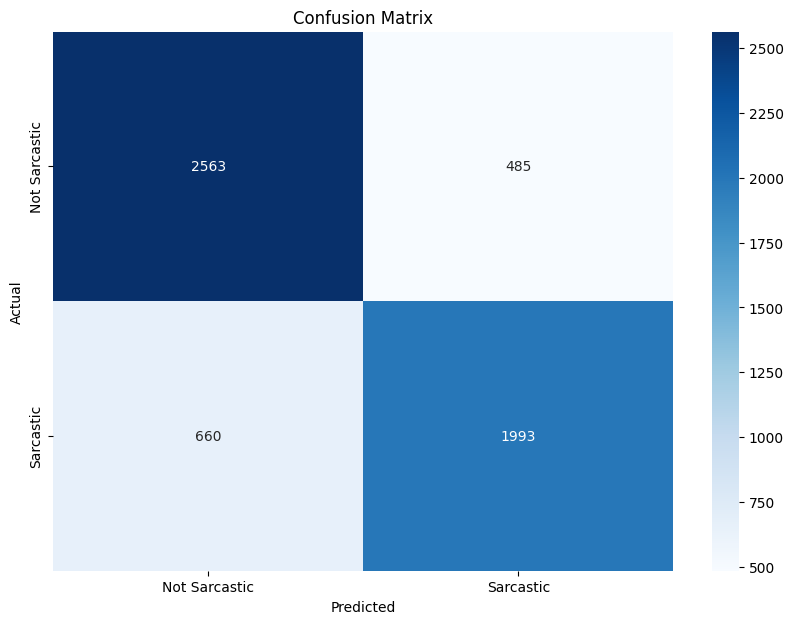

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()